# Tensorflow Speech Recognition Challenge
### Competition
- you're challenged to use the Speech Commands Dataset to build an algorithm that understands simple spoken commands.
- There are only 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown.
- https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

### Reference
- Speech representation and data exploration, https://www.kaggle.com/davids1992/speech-representation-and-data-exploration
- Light-Weight CNN LB 0.74, https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74
- WavCeption V1: a 1-D Inception approach (LB 0.76), https://www.kaggle.com/ivallesp/wavception-v1-a-1-d-inception-approach-lb-0-76

## 0. Import Packages

In [33]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

import glob
import re
import gc

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras

import shutil
import random
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import IPython
from numpy.fft import rfft, irfft
import itertools

import IPython.display as ipd
import scipy as sp
import tensorflow as tf
%matplotlib inline

## 1. Visualization

### check!
- There are two theories of a human hearing - place and temporal
In speech recognition, I see two main tendencies - to input spectrogram (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

In [34]:
# Wave and spectrogram
train_audio_path = 'train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

### check!
- Note, that we are taking logarithm of spectrogram values.  
It will make our plot much more clear, moreover, it is strictly connected to the way people hear.  
We need to assure that there are no 0 values as input to logarithm.

In [1]:
# Define a function that calculates spectrogram.

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

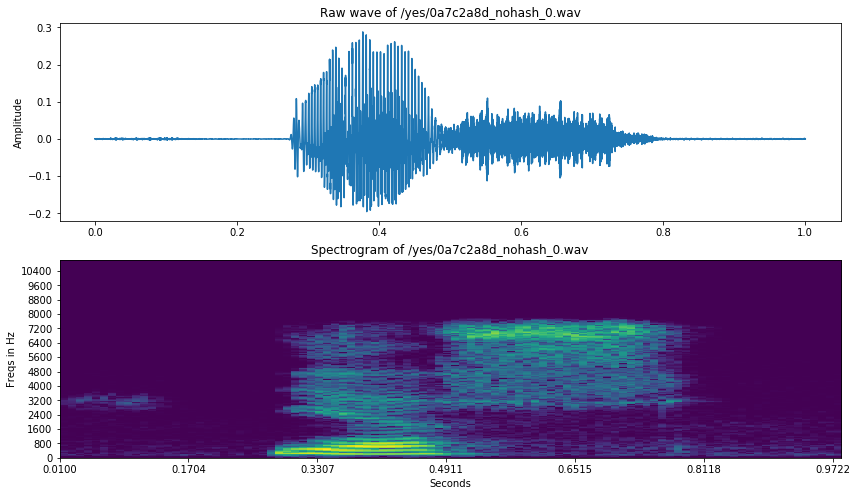

In [36]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

plt.show()

### check!
- If we use spectrogram as an input features for NN, we have to remember to normalize features.

In [37]:
# normalize
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

### MFCC
- MFCC explained You can see, that it is well prepared to imitate human hearing properties.  
You can calculate Mel power spectrogram and MFCC using for example librosa python package.

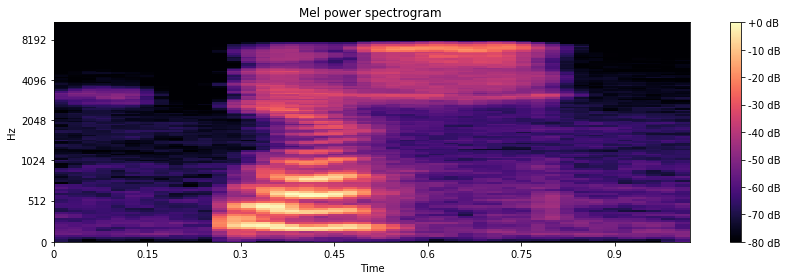

In [38]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

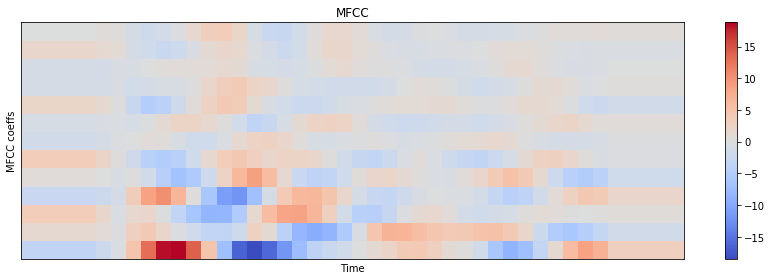

In [39]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [41]:
# Silence removal
ipd.Audio(samples, rate = sample_rate)

### Silence removal
- I consider that some VAD (Voice Activity Detection) will be really useful here.  
Although the words are short, there is a lot of silence in them. A decent VAD can **reduce training size** a lot, accelerating training speed significantly.   
Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [43]:
# after remove
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

### check!
- It is impossible to cut all the files manually and do this basing on the simple plot.  
But you can use for example webrtcvad package to have a good VAD.

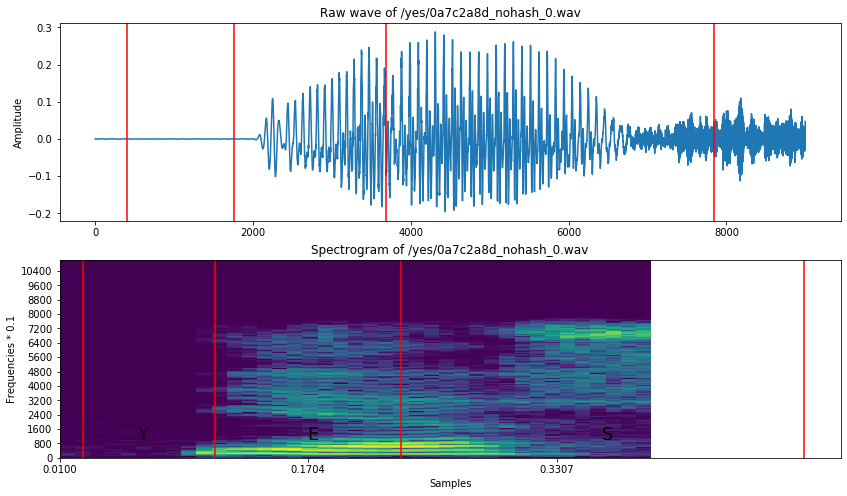

In [44]:
# plot it again, together with guessed alignment of 'y' 'e' 's' graphems
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

### Resampling - dimensionality reduction
- Another way to reduce the dimensionality of our data is to **resample recordings**.  
we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.  
experiments can be done much faster with smaller training size.  
We'll need to calculate FFT (Fast Fourier Transform).

In [2]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [46]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [47]:
ipd.Audio(samples, rate=sample_rate)

In [48]:
ipd.Audio(resampled, rate=new_sample_rate)  # Almost no difference!

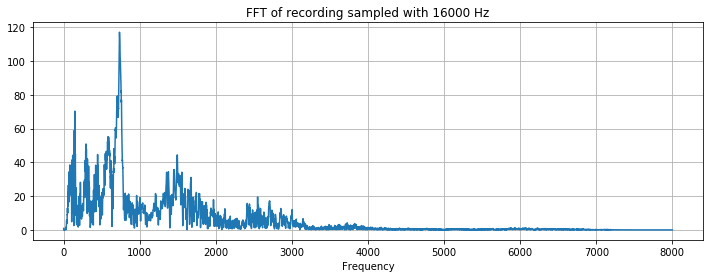

In [49]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

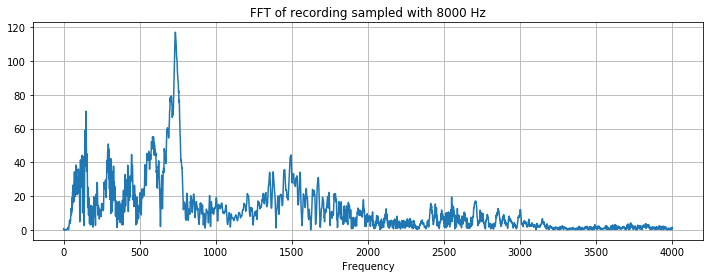

In [50]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

## 2. Dataset investigation

In [51]:
# Number of records
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


### Deeper into recordings
- Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.  
Nevertheless, it is extremely important to split the dataset in a way   
that one speaker doesn't occur in both train and test sets. Just take a look and listen to this two examlpes:

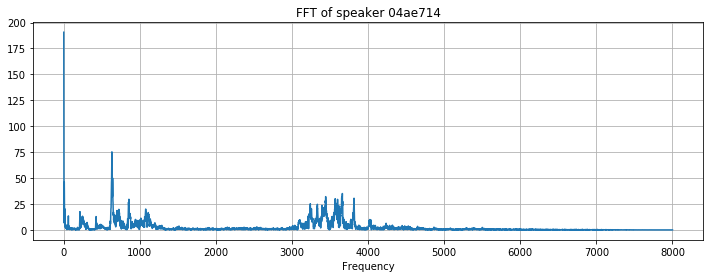

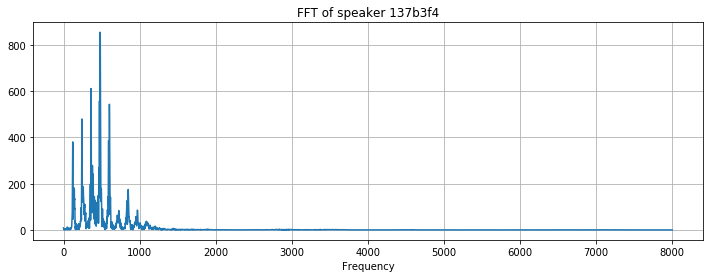

In [53]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [54]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [55]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))  # There are also recordings with some weird silence

Speaker 137b3f4


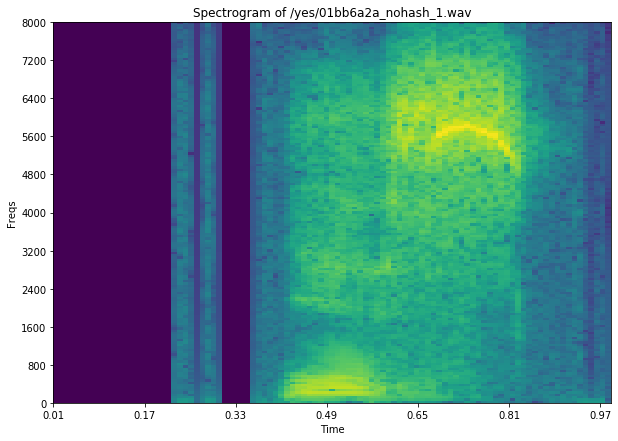

In [56]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()


- It means, that we have to prevent overfitting to the very specific acoustical environments.

In [57]:
# Recordings length
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


- That's suprising, and there is a lot of them. We can pad them with zeros.

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


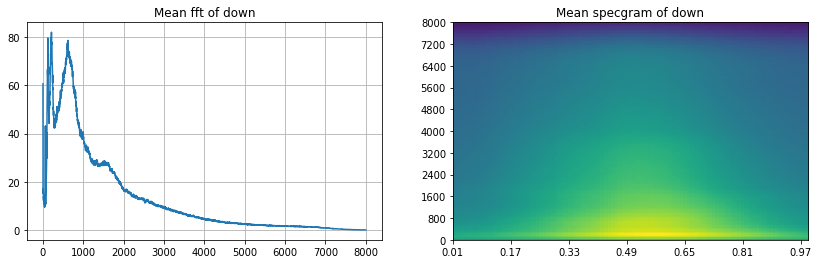

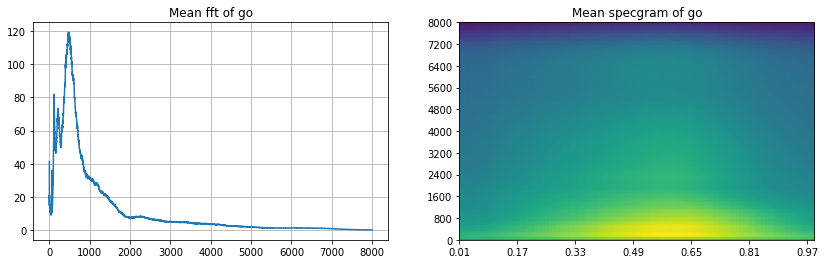

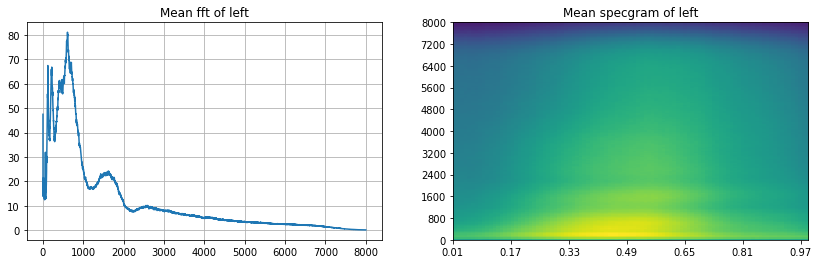

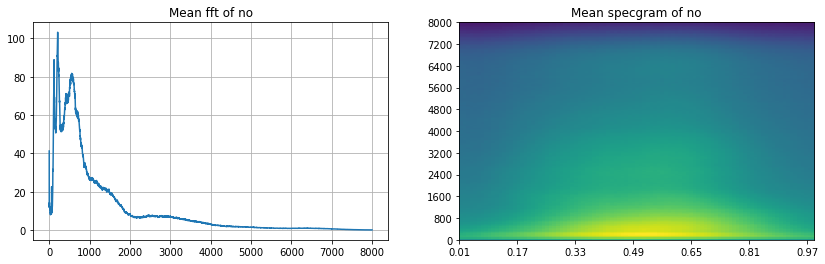

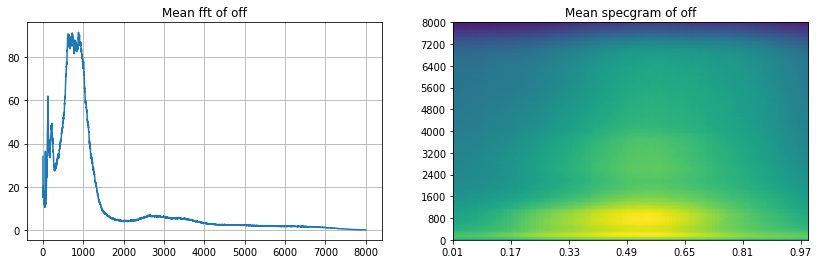

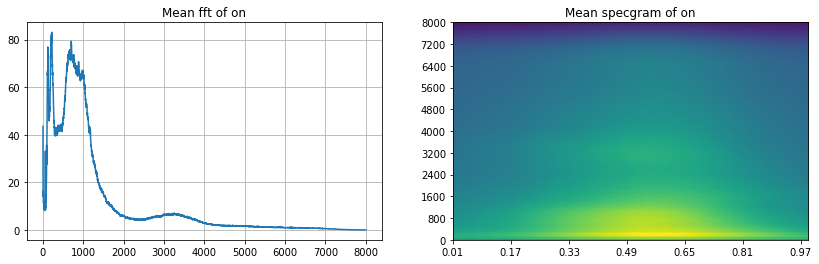

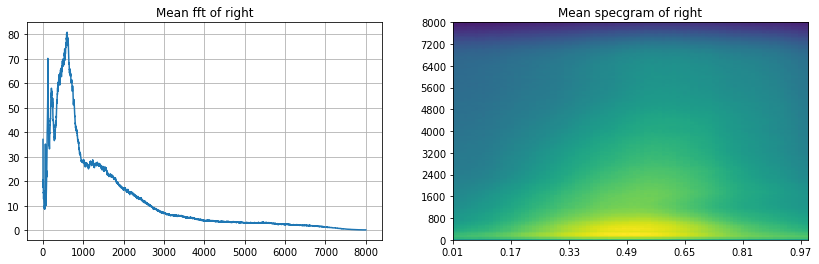

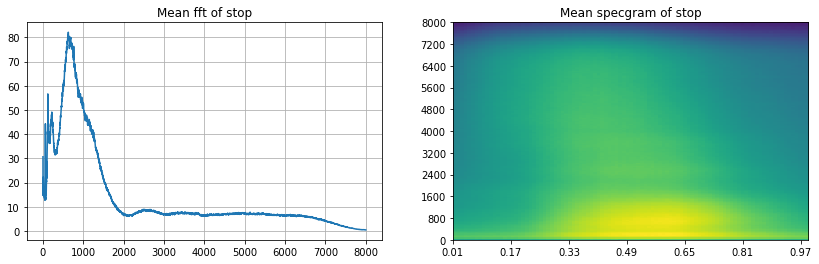

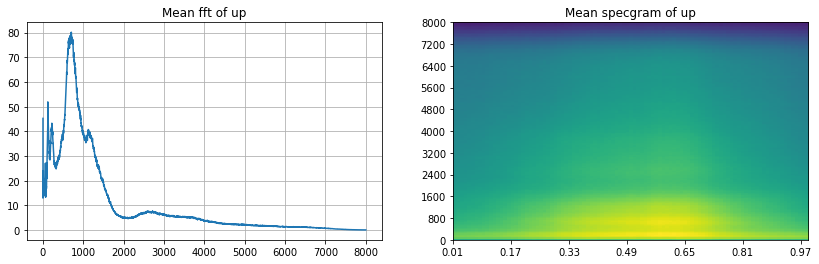

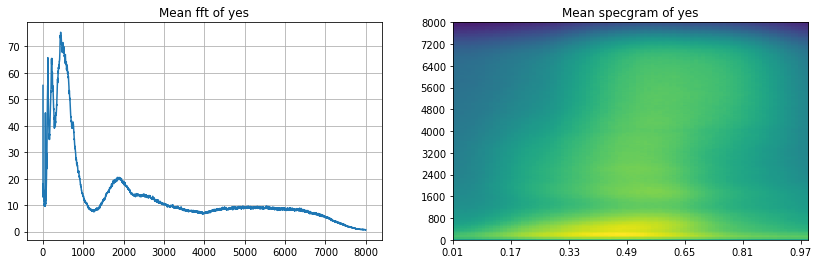

In [58]:
# Mean spectrograms and FFT
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

In [59]:
# Frequency components across the words
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

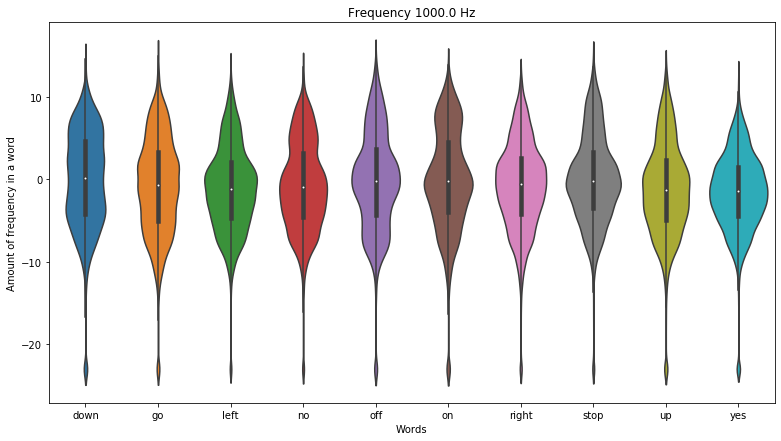

In [60]:
violinplot_frequency(dirs, 20)

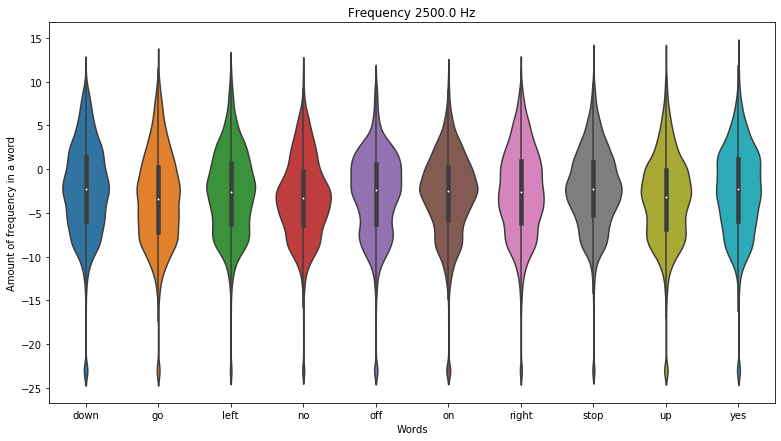

In [61]:
violinplot_frequency(dirs, 50)

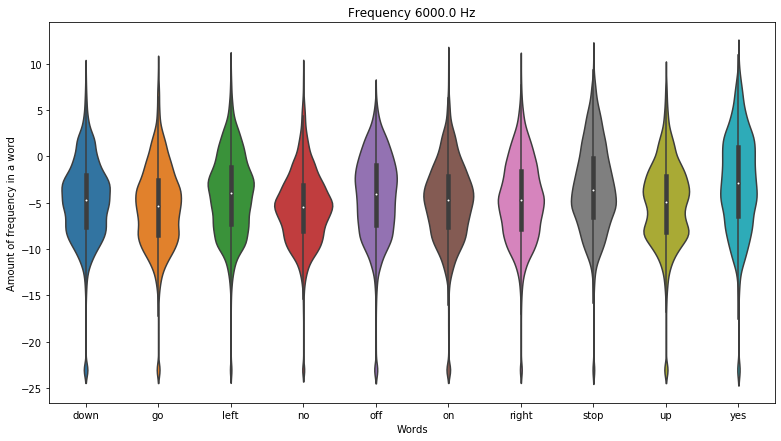

In [62]:
violinplot_frequency(dirs, 120)

### Anomaly detection
- We should check if there are any recordings that somehow stand out from the rest.  
We can lower the dimensionality of the dataset and interactively check for any anomaly. -> **PCA**

In [63]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [64]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


In [65]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


In [66]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav'))

Recording seven/e4b02540_nohash_0.wav


## 3. Light-Weight CNN

- original sample rate : 16000 -> resample it to 8000 to reduce data size.

In [16]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'..'
out_path = r'.'
model_path = r'.'

train_data_path = os.path.join(root_path, '', 'train', 'audio')
test_data_path = os.path.join(root_path, '', 'test', 'audio')

In [10]:
#  grab all wav files inside train data folder.

def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [11]:
# pad audios that are less than 16000(1 second) with 0s to make them all have the same length.
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

# chop audios that are larger than 16000(eg. wav files in background noises folder) to 16000 in length. 
# In addition, it will create several chunks out of one large wav files given the parameter 'num'.    
def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

# transform labels into dummies values. It's used in combination with softmax to predict the label
def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [19]:
labels, fnames = list_wavs_fname(train_data_path)

new_sample_rate = 8000
y_train = []
x_train = []

for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train.append(label)
        x_train.append(specgram)
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))
y_train = label_transform(y_train)
label_index = y_train.columns.values
y_train = y_train.values
y_train = np.array(y_train)
del labels, fnames
gc.collect()

In [20]:
input_shape = (99, 81, 1)
nclass = 12
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss=losses.binary_crossentropy)
model.summary()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)
model.fit(x_train, y_train, batch_size=16, validation_data=(x_valid, y_valid), epochs=3, shuffle=True, verbose=2)

model.save(os.path.join(model_path, 'cnn.model'))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 99, 81, 1)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 39, 8)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 39, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 37, 16)        1168

In [75]:
def test_data_generator(batch=16):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)
        imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
        yield fnames, imgs
    raise StopIteration()

In [21]:
exit() #delete this
del x_train, y_train
gc.collect()

index = []
results = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = model.predict(imgs)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'sub.csv'), index=False)

## 4. WavCeption V1: just a 1-D Inception approach

- The WavCeption V1 network seems to produce impressive results compared to a regular convolutional neural network,  
but in this competition it seems that there is a hard-work on the pre-processing and unknown tracks management.  
It is based on the Google's inception network, the same idea.
By running the model for 12h without struggling too much I achieved 0.76 in the leaderboard (with 0.84 in local test). 

In [23]:
# Noise generation functions
def ms(x):
    """Mean value of signal `x` squared.
    :param x: Dynamic quantity.
    :returns: Mean squared of `x`.
    """
    return (np.abs(x)**2.0).mean()

def normalize(y, x=None):
    """normalize power in y to a (standard normal) white noise signal.
    Optionally normalize to power in signal `x`.
    #The mean power of a Gaussian with :math:`\\mu=0` and :math:`\\sigma=1` is 1.
    """
    #return y * np.sqrt( (np.abs(x)**2.0).mean() / (np.abs(y)**2.0).mean() )
    if x is not None:
        x = ms(x)
    else:
        x = 1.0
    return y * np.sqrt( x / ms(y) )
    #return y * np.sqrt( 1.0 / (np.abs(y)**2.0).mean() )

def white_noise(N, state=None):
    state = np.random.RandomState() if state is None else state
    return state.randn(N)

def pink_noise(N, state=None):

    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def blue_noise(N, state=None):
    """
    Blue noise. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power increases with 6 dB per octave.
    Power density increases with 3 dB per octave. 
    
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X)))# Filter
    y = (irfft(X*S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def brown_noise(N, state=None):
    """
    Violet noise.
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power decreases with -3 dB per octave.
    Power density decreases with 6 dB per octave. 
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = (np.arange(len(X))+1)# Filter
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def violet_noise(N, state=None):
    """
    Violet noise. Power increases with 6 dB per octave. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power increases with +9 dB per octave.
    Power density increases with +6 dB per octave. 
    
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = (np.arange(len(X)))# Filter
    y = (irfft(X*S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

In [24]:
# Utilities to modularize tensorflow common actions
# Tf Utils
def get_tensorflow_configuration(device="0", memory_fraction=1):
    """
    Function for selecting the GPU to use and the amount of memory the process is allowed to use
    :param device: which device should be used (str)
    :param memory_fraction: which proportion of memory must be allocated (float)
    :return: config to be passed to the session (tf object)
    """
    device = str(device)
    config = tf.ConfigProto()
    config.allow_soft_placement = True
    config.gpu_options.per_process_gpu_memory_fraction = memory_fraction
    config.gpu_options.visible_device_list = device
    return(config)


def start_tensorflow_session(device="0", memory_fraction=1):
    """
    Starts a tensorflow session taking care of what GPU device is going to be used and
    which is the fraction of memory that is going to be pre-allocated.
    :device: string with the device number (str)
    :memory_fraction: fraction of memory that is going to be pre-allocated in the specified
    device (float [0, 1])
    :return: configured tf.Session
    """
    return(tf.Session(config=get_tensorflow_configuration(device=device, memory_fraction=memory_fraction)))


def get_summary_writer(session, logs_path, project_id, version_id):
    """
    For Tensorboard reporting
    :param session: opened tensorflow session (tf.Session)
    :param logs_path: path where tensorboard is looking for logs (str)
    :param project_id: name of the project for reporting purposes (str)
    :param version_id: name of the version for reporting purposes (str)
    :return summary_writer: the tensorboard writer
    """
    path = os.path.join(logs_path,"{}_{}".format(project_id, version_id)) 
    if os.path.exists(path):
        shutil.rmtree(path)
    summary_writer = tf.summary.FileWriter(path, graph_def=session.graph_def)
    return(summary_writer)

In [35]:
# Modules to deal with the paths
# Common paths
def _norm_path(path):
    """
    Decorator function intended for using it to normalize a the output of a path retrieval function. Useful for
    fixing the slash/backslash windows cases.
    """
    def normalize_path(*args, **kwargs):
        return os.path.normpath(path(*args, **kwargs))
    return normalize_path


def _assure_path_exists(path):
    """
    Decorator function intended for checking the existence of a the output of a path retrieval function. Useful for
    fixing the slash/backslash windows cases.
    """
    def assure_exists(*args, **kwargs):
        p=path(*args, **kwargs)
        assert os.path.exists(p), "the following path does not exist: '{}'".format(p)
        return p
    return assure_exists


def _is_output_path(path):
    """
    Decorator function intended for grouping the functions which are applied over the output of an output path retrieval
    function
    """
    @_norm_path
    @_assure_path_exists
    def check_existence_or_create_it(*args, **kwargs):
        if not os.path.exists(path(*args, **kwargs)):
            "Path does not exist... creating it: {}".format(path(*args, **kwargs))
            os.makedirs(path(*args, **kwargs))
        return path(*args, **kwargs)
    return check_existence_or_create_it


def _is_input_path(path):
    """
    Decorator function intended for grouping the functions which are applied over the output of an input path retrieval
    function
    """
    @_norm_path
    @_assure_path_exists
    def check_existence(*args, **kwargs):
        return path(*args, **kwargs)
    return check_existence

@_is_input_path
def get_train_path():
    path = "train"
    return path

@_is_input_path
def get_test_path():
    path = "test"
    return path

@_is_input_path
def get_train_audio_path():
    path = os.path.join(get_train_path(), "audio")
    return path

@_is_input_path
def get_scoring_audio_path():
    path = os.path.join(get_test_path(), "audio")
    return path

@_is_output_path
def get_submissions_path():
    path = "../working/output"
    return path

@_is_output_path
def get_silence_path():
    path = "../working/silence"
    return path

In [26]:
# Common general-purpose utilities
# Utilities
flatten = lambda l: [item for sublist in l for item in sublist]

def batching(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [27]:
# Data handling tools
def read_wav(filepath, pad=True):
    """
    Given the filepath of a wav file, this function reads it, normalizes it and pads
    it to assure it has 16k samples.
    :param filepath: existing filepath of a wav file (str)
    :param pad: is padding required? (bool)
    :returns: the sample and the target variable (tuple of (np.array, str))
    """
    sample_rate, x = wavfile.read(filepath)
    target = os.path.split(os.path.split(filepath)[0])[1]
    assert sample_rate==16000
    if pad:
        return np.pad(x, (0, 16000-len(x)), mode="constant")/32768, target
    else:
        return x/32768, target

def get_batcher(list_of_paths, batch_size, label_encoder=None, scoring=False):
    """
    Builds a batch generator given a list of batches
    :param list_of_paths: list of tuples with elements of format (filepath, target) (list)
    :param batch_size: size of the batch (int)
    :param label_encoder: fitted LabelEncoder (sklearn.LabelEncoder|optional)
    :param scoring: should the target be considered? (bool)
    :returns: batch generator
    """
    for filepaths in batching(list_of_paths, batch_size):
        wavs, targets = zip(*list(map(read_wav, filepaths)))
        if scoring:
            yield np.expand_dims(np.row_stack(wavs), 2), filepaths
        else:
            if label_encoder is None:
                yield np.expand_dims(np.row_stack(wavs), 2), np.row_stack(targets)
            else:
                yield np.expand_dims(np.row_stack(wavs), 2), np.expand_dims(label_encoder.transform(np.squeeze(targets)),1)

### Architecture building blocks
- Inception-1D (a.k.a wavception) is a module I designed some weeks ago for this problem.  
It substantially enhances the performance of a regular convolutional neural net.

In [29]:
class BatchNorm(object):
    def __init__(self, epsilon=1e-5, momentum=0.999, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x,
                                            decay=self.momentum,
                                            updates_collections=None,
                                            epsilon=self.epsilon,
                                            scale=True,
                                            is_training=train,
                                            scope=self.name)
    
    

def inception_1d(x, is_train, depth, norm_function, activ_function, name):
    """
    Inception 1D module implementation. 
    :param x: input to the current module (4D tensor with channels-last)
    :param is_train: it is intented to be a boolean placeholder for controling the BatchNormalization behavior (0D tensor)
    :param depth: linearly controls the depth of the network (int)
    :param norm_function: normalization class (same format as the BatchNorm class above)
    :param activ_function: tensorflow activation function (e.g. tf.nn.relu) 
    :param name: name of the variable scope (str)
    """
    with tf.variable_scope(name):
        x_norm = norm_function(name="norm_input")(x, train=is_train)

        # Branch 1: 64 x conv 1x1 
        branch_conv_1_1 = tf.layers.conv1d(inputs=x_norm, filters=16*depth, kernel_size=1,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_1_1")
        branch_conv_1_1 = norm_function(name="norm_conv_1_1")(branch_conv_1_1, train=is_train)
        branch_conv_1_1 = activ_function(branch_conv_1_1, "activation_1_1")

        # Branch 2: 128 x conv 3x3 
        branch_conv_3_3 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_3_3_1")
        branch_conv_3_3 = norm_function(name="norm_conv_3_3_1")(branch_conv_3_3, train=is_train)
        branch_conv_3_3 = activ_function(branch_conv_3_3, "activation_3_3_1")

        branch_conv_3_3 = tf.layers.conv1d(inputs=branch_conv_3_3, filters=32*depth, kernel_size=3, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_3_3_2")
        branch_conv_3_3 = norm_function(name="norm_conv_3_3_2")(branch_conv_3_3, train=is_train)
        branch_conv_3_3 = activ_function(branch_conv_3_3, "activation_3_3_2")

        # Branch 3: 128 x conv 5x5 
        branch_conv_5_5 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_5_5_1")
        branch_conv_5_5 = norm_function(name="norm_conv_5_5_1")(branch_conv_5_5, train=is_train)
        branch_conv_5_5 = activ_function(branch_conv_5_5, "activation_5_5_1")

        branch_conv_5_5 = tf.layers.conv1d(inputs=branch_conv_5_5, filters=32*depth, kernel_size=5, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_5_5_2")
        branch_conv_5_5 = norm_function(name="norm_conv_5_5_2")(branch_conv_5_5, train=is_train)
        branch_conv_5_5 = activ_function(branch_conv_5_5, "activation_5_5_2")

        # Branch 4: 128 x conv 7x7
        branch_conv_7_7 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_7_7_1")
        branch_conv_7_7 = norm_function(name="norm_conv_7_7_1")(branch_conv_7_7, train=is_train)
        branch_conv_7_7 = activ_function(branch_conv_7_7, "activation_7_7_1")

        branch_conv_7_7 = tf.layers.conv1d(inputs=branch_conv_7_7, filters=32*depth, kernel_size=5, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_7_7_2")
        branch_conv_7_7 = norm_function(name="norm_conv_7_7_2")(branch_conv_7_7, train=is_train)
        branch_conv_7_7 = activ_function(branch_conv_7_7, "activation_7_7_2")

        # Branch 5: 16 x (max_pool 3x3 + conv 1x1)
        branch_maxpool_3_3 = tf.layers.max_pooling1d(inputs=x_norm, pool_size=3, strides=1, padding="same", name="maxpool_3")
        branch_maxpool_3_3 = norm_function(name="norm_maxpool_3_3")(branch_maxpool_3_3, train=is_train)
        branch_maxpool_3_3 = tf.layers.conv1d(inputs=branch_maxpool_3_3, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_maxpool_3")

        # Branch 6: 16 x (max_pool 5x5 + conv 1x1)
        branch_maxpool_5_5 = tf.layers.max_pooling1d(inputs=x_norm, pool_size=5, strides=1, padding="same", name="maxpool_5")
        branch_maxpool_5_5 = norm_function(name="norm_maxpool_5_5")(branch_maxpool_5_5, train=is_train)
        branch_maxpool_5_5 = tf.layers.conv1d(inputs=branch_maxpool_5_5, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_maxpool_5")

        # Branch 7: 16 x (avg_pool 3x3 + conv 1x1)
        branch_avgpool_3_3 = tf.layers.average_pooling1d(inputs=x_norm, pool_size=3, strides=1, padding="same", name="avgpool_3")
        branch_avgpool_3_3 = norm_function(name="norm_avgpool_3_3")(branch_avgpool_3_3, train=is_train)
        branch_avgpool_3_3 = tf.layers.conv1d(inputs=branch_avgpool_3_3, filters=16, kernel_size=1,
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_avgpool_3")

        # Branch 8: 16 x (avg_pool 5x5 + conv 1x1)
        branch_avgpool_5_5 = tf.layers.average_pooling1d(inputs=x_norm, pool_size=5, strides=1, padding="same", name="avgpool_5")
        branch_avgpool_5_5 = norm_function(name="norm_avgpool_5_5")(branch_avgpool_5_5, train=is_train)
        branch_avgpool_5_5 = tf.layers.conv1d(inputs=branch_avgpool_5_5, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_avgpool_5")

        # Concatenate
        output = tf.concat([branch_conv_1_1, branch_conv_3_3, branch_conv_5_5, branch_conv_7_7, branch_maxpool_3_3, 
                           branch_maxpool_5_5, branch_avgpool_3_3, branch_avgpool_5_5], axis=-1)
        return output

In [36]:
# Load and prepare Data
# Synthetic and provided noise addition
filepaths_noise = glob.glob(os.path.join(get_train_audio_path(), "_background_noise_", "*.wav"))

noise = np.concatenate(list(map(lambda x: read_wav(x, False)[0], filepaths_noise)))
noise = np.concatenate([noise, noise[::-1]])
synthetic_noise = np.concatenate([white_noise(N=16000*30, state=np.random.RandomState(655321)), 
                                  blue_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  pink_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  brown_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  violet_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  np.zeros(16000*60)])
synthetic_noise /= np.max(np.abs(synthetic_noise))
synthetic_noise = np.concatenate([synthetic_noise, (synthetic_noise+synthetic_noise[::-1])/2])
all_noise = np.concatenate([noise, synthetic_noise])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: WavFileWarning:

Chunk (non-data) not understood, skipping it.



In [37]:
np.random.seed(655321)
random.seed(655321)

path = get_silence_path()

if not os.path.exists(path):
    os.makedirs(path) # It fails in kaggle kernel due to the read-only filesystem

for noise_clip_no in tqdm(range(8000)):
    if noise_clip_no<=4000:
        idx = np.random.randint(0, len(noise)-16000)
        clip = noise[idx:(idx+16000)]
    else:
        idx = np.random.randint(0, len(synthetic_noise)-16000)
        clip = synthetic_noise[idx:(idx+16000)]
    wavfile.write(os.path.join(path, "{0:04d}.wav".format(noise_clip_no)), 16000, 
                               ((32767*clip/np.max(np.abs(clip))).astype(np.int16)))
    

 49%|█████████████████████████████████████▊                                       | 3934/8000 [00:05<00:05, 769.99it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in true_divide

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:11<00:00, 673.80it/s]


In [38]:
filepaths = glob.glob(os.path.join(get_train_audio_path(), "**/*.wav"), recursive=True)
filepaths += glob.glob(os.path.join(get_silence_path(), "**/*.wav"), recursive=True)
filepaths = list(filter(lambda fp: "_background_noise_" not in fp, filepaths))
validation_list = open(os.path.join(get_train_path(), "validation_list.txt")).readlines()
test_list = open(os.path.join(get_train_path(), "testing_list.txt")).readlines()
validation_list = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip()), validation_list))
testing_list = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip()), test_list))
training_list = np.setdiff1d(filepaths, validation_list+testing_list).tolist()

In [39]:
random.seed(655321)
random.shuffle(filepaths)
random.shuffle(validation_list)
random.shuffle(testing_list)
random.shuffle(training_list)

In [ ]:
# Quick Unit-Tests
# Test number of files and their consistencies
assert all(map(lambda fp: os.path.splitext(fp)[1]==".wav", filepaths))
assert len(filepaths)==64727 - 6 + 8000
assert len(training_list) == len(filepaths) - 6798 - 6835 
assert len(validation_list) == 6798
assert len(testing_list) == 6835

# Test file existence
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), validation_list))
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), testing_list))
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), training_list))
assert set(validation_list + testing_list + training_list) == set(filepaths)

# Test non-overlap among sets
assert len(np.intersect1d(validation_list, testing_list))==0
assert len(np.intersect1d(training_list, testing_list))==0
assert len(np.intersect1d(training_list, validation_list))==0

In [40]:
# Classes processing
cardinal_classes = list(set(map(lambda fp:os.path.split(os.path.split(fp)[0])[1], filepaths)))
le_classes = LabelEncoder().fit(cardinal_classes)
Counter(map(lambda fp:os.path.split(os.path.split(fp)[0])[1], filepaths))

Counter({'no': 2375,
         'yes': 2377,
         'stop': 2380,
         'nine': 2364,
         'left': 2353,
         'dog': 1746,
         'wow': 1745,
         'up': 2375,
         'one': 2370,
         'six': 2369,
         'zero': 2376,
         'two': 2373,
         'sheila': 1734,
         'tree': 1733,
         'silence': 8000,
         'four': 2372,
         'marvin': 1746,
         'bed': 1713,
         'right': 2367,
         'seven': 2377,
         'cat': 1733,
         'eight': 2352,
         'five': 2357,
         'on': 2367,
         'happy': 1742,
         'off': 2357,
         'three': 2356,
         'go': 2372,
         'down': 2359,
         'bird': 1731,
         'house': 1750})

In [41]:
# Quick Unit-Tests
# Test data preparation
_gen_test = get_batcher(filepaths, 1000)
batch_a_wav, batch_a_target = next(_gen_test)
batch_b_wav, batch_b_target = next(_gen_test)
_gen_test_le = get_batcher(filepaths, 1000, label_encoder=le_classes)
batch_le_wav, batch_le_target = next(_gen_test_le)

# Test batch matrix shape coherences
assert batch_a_wav.shape == (1000, 16000, 1)
assert batch_le_wav.shape == (1000, 16000, 1)
assert batch_a_wav.shape == batch_b_wav.shape == batch_le_wav.shape

# Test batch reproducibility
assert np.sum(np.abs(batch_a_wav-batch_b_wav)) != 0
assert len(batch_a_target) == len(batch_b_target) == len(batch_le_target)
assert any(batch_a_target != batch_b_target)

# Test classes label encoder
assert all(batch_le_target == np.expand_dims(le_classes.transform(np.squeeze(batch_a_target)),1))

In [42]:
# Architecture design
class NameSpacer:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

class Architecture:
    def __init__(self, class_cardinality, seq_len=16000, name="architecture"):
        self.seq_len = seq_len
        self.class_cardinality = class_cardinality
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.name=name
        self.define_computation_graph()
        
        #Aliases
        self.ph = self.placeholders
        self.op = self.optimizers
        self.summ = self.summaries

    def define_computation_graph(self):
        # Reset graph
        tf.reset_default_graph()
        self.placeholders = NameSpacer(**self.define_placeholders())
        self.core_model = NameSpacer(**self.define_core_model())
        self.losses = NameSpacer(**self.define_losses())
        self.optimizers = NameSpacer(**self.define_optimizers())
        self.summaries = NameSpacer(**self.define_summaries())

    def define_placeholders(self):
        with tf.variable_scope("Placeholders"):
            wav_in = tf.placeholder(dtype=tf.float32, shape=(None, self.seq_len, 1), name="wav_in")
            is_train = tf.placeholder(dtype=tf.bool, shape=None, name="is_train")
            target = tf.placeholder(dtype=tf.int32, shape=(None, 1), name="target")
            acc_dev = tf.placeholder(dtype=tf.float32, shape=None, name="acc_dev")
            loss_dev = tf.placeholder(dtype=tf.float32, shape=None, name="loss_dev")
            return({"wav_in": wav_in, "target": target, "is_train": is_train, "acc_dev": 
                    acc_dev, "loss_dev": loss_dev})
        
    def define_core_model(self):
        with tf.variable_scope("Core_Model"):
            x = inception_1d(x=self.placeholders.wav_in, is_train=self.placeholders.is_train, 
                             norm_function=BatchNorm, activ_function=tf.nn.relu, depth=1,
                             name="Inception_1_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=1, name="Inception_1_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=1, name="Inception_2_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=1, name="Inception_2_3")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_2")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_3_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_3_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_3")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_4_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=2, name="Inception_4_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_4")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_5_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_5_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_5")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_6_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=3, name="Inception_6_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_6")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_7_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_7_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_7")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_8_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_8_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_8")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_9_1")
            x = inception_1d(x=x, is_train=self.placeholders.is_train, norm_function=BatchNorm, 
                             activ_function=tf.nn.relu, depth=4, name="Inception_9_2")
            x = tf.layers.max_pooling1d(x, 2, 2, name="maxpool_9")
            x = tf.contrib.layers.flatten(x)
            x = tf.layers.dense(BatchNorm(name="bn_dense_1")(x,train=self.placeholders.is_train),
                                128, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="dense_1")
            output = tf.layers.dense(BatchNorm(name="bn_dense_2")(x,train=self.placeholders.is_train),
                                self.class_cardinality, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="output")
            return({"output": output})
        
    def define_losses(self):
        with tf.variable_scope("Losses"):
            softmax_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.squeeze(self.placeholders.target), 
                                                                        logits=self.core_model.output,
                                                                        name="softmax")
            return({"softmax": softmax_ce})

    def define_optimizers(self):
        with tf.variable_scope("Optimization"):
            op = self.optimizer.minimize(self.losses.softmax)
            return({"op": op})

    def define_summaries(self):
        with tf.variable_scope("Summaries"):
            ind_max = tf.squeeze(tf.cast(tf.argmax(self.core_model.output, axis=1), tf.int32))
            target = tf.squeeze(self.placeholders.target)
            acc= tf.reduce_mean(tf.cast(tf.equal(ind_max, target), tf.float32))
            loss = tf.reduce_mean(self.losses.softmax)
            train_scalar_probes = {"accuracy": acc, 
                                   "loss": loss}
            train_performance_scalar = [tf.summary.scalar(k, tf.reduce_mean(v), family=self.name) 
                                        for k, v in train_scalar_probes.items()]
            train_performance_scalar = tf.summary.merge(train_performance_scalar)

            dev_scalar_probes = {"acc_dev": self.placeholders.acc_dev, 
                                 "loss_dev": self.placeholders.loss_dev}
            dev_performance_scalar = [tf.summary.scalar(k, v, family=self.name) for k, v in dev_scalar_probes.items()]
            dev_performance_scalar = tf.summary.merge(dev_performance_scalar)
            return({"accuracy": acc, "loss": loss, "s_tr": train_performance_scalar, "s_de": dev_performance_scalar})

- GPU

In [43]:
# Run model
net = Architecture(class_cardinality=len(cardinal_classes), name="wavception")
sess = start_tensorflow_session(device="1")
sw = get_summary_writer(sess, "~/.logs_tensorboard/", "wavception", "V1") # Adjust your tensorboard logs path here
c=0

sess.run(tf.global_variables_initializer())
np.random.seed(655321)
random.seed(655321)

for epoch in range(50000):
    random.shuffle(training_list)
    batcher = get_batcher(training_list, 16, le_classes)
    for i, (batch_x, batch_y) in enumerate(batcher):
        _, loss, acc, s = sess.run([net.op.op, net.losses.softmax, net.summ.accuracy, net.summ.s_tr],
                                 feed_dict={net.ph.wav_in: batch_x, net.ph.target: batch_y, 
                                            net.ph.is_train: True})
        print("[{0:04d}|{1:04d}] Accuracy train: {2:.2f}%".format(epoch, i, acc*100))
        sw.add_summary(s, c)
        
        if c%1000==0: # Validation
            accuracies_dev=[]
            losses_dev=[]
            batcher = get_batcher(validation_list, 16, le_classes)
            for i, (batch_x, batch_y) in enumerate(batcher):
                acc, loss= sess.run([net.summ.accuracy, net.summ.loss], 
                               feed_dict={net.ph.wav_in: batch_x, net.ph.target: batch_y, 
                                          net.ph.is_train: False})
                accuracies_dev.append(acc)
                losses_dev.append(loss)
            s = sess.run(net.summ.s_de, feed_dict={net.ph.acc_dev: np.mean(accuracies_dev),
                                                        net.ph.loss_dev: np.mean(losses_dev)})
            sw.add_summary(s, c)
        c += 1

In [44]:
# Test accuracy
accuracies=[]
batcher = get_batcher(testing_list, 64, le_classes)
for i, (batch_x, batch_y) in tqdm(enumerate(batcher)):
    acc= sess.run(net.summ.accuracy, feed_dict={net.ph.wav_in: batch_x, net.ph.target: batch_y, 
                                                     net.ph.is_train: False})
    accuracies.append(acc)